In [64]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt

In [65]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    weight = 1/len(x_init) # Compute equal weight
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate) # Round down the number of shares to make sure we are trading integer number of shares
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex() 
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Implement Cplex minimizer
    n = len(x_init)  #n=20
    c  = [0.0] * n  #Linear part of the equation
    lb = [0.0] * n  #Lower bound
    ub = [1.0] * n  #Upper bound
    A = []
    for k in range(n):  #Create constraint matrix A
      A.append([[0],[1.0]])
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)] #Crreate the quadratic part of the equation
    cpx.objective.set_quadratic(Qmat)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    weight = np.asarray(cpx.solution.get_values())
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate) # Round down the number of shares to make sure we are trading integer number of shares
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    cpx = cplex.Cplex() 
    cpx.objective.set_sense(cpx.objective.sense.minimize) # Implement Cplex minimizer
    n = len(x_init)  #n=20
    r_rf = 0.025 #Risk-free rate
    c  = [0.0] * (n+1) #Linear part of the equation, one more input added, which is the "K"
    lb = [0.0] * (n+1) #Lower bound, one more input added, which is the "K"
    A = []
    for k in range(n):
      A.append([[0,1],[mu[k]-r_rf/252,1]]) #Create constraint matrix A, risk-free rate/252 because the given risk-free rate is annually but we want to compute daily return
    A.append([[0,1],[0,-1]])
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EE")
    var_names = ["y_%s" % i for i in range(1,n+2)]
    cpx.variables.add(obj=c, lb=lb, columns=A, names=var_names)
    Qmat = [[list(2*Q[k,:])] for k in range(n)] #Create the quadratic part of the equation, one more row and column added, with "0".
    for k in range (n):
        Qmat[k][0].append(0)
    Qmat.append([list(np.zeros(n+1))])
    Qmat = [[list(range(n+1)), Qmat[k][0]] for k in range(n+1)]
    cpx.objective.set_quadratic(Qmat)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    y = np.asarray(cpx.solution.get_values())
    weight = y[:-1]/y[-1] #Weight is computed by y/k. The last element of input is "K"
    portfolio_price = np.dot(x_init, cur_prices) + cash_init
    x_optimal_accurate = portfolio_price * weight / cur_prices
    x_optimal = np.floor(x_optimal_accurate)  # Round down the number of shares to make sure we are trading integer number of shares
    transaction_fee = np.dot(np.absolute(x_optimal - x_init), cur_prices)*0.005
    cash_optimal = portfolio_price - transaction_fee - np.dot(x_optimal, cur_prices)
    #print(cash_optimal)
    return x_optimal, cash_optimal

In [66]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

In [67]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

In [68]:
dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

In [69]:
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

In [70]:
# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [71]:
# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

In [72]:
# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))


Initial portfolio value = $ 1000002.12



In [73]:
# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

In [74]:
# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year, = 12
N = len(df.columns)-1   #Number of assets  = 20
N_days = len(dates)    # = 504

In [75]:
# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025

In [76]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1 comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

In [77]:
portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight_list_all = []

In [78]:
for period in range(1, N_periods+1): #period = 1-12
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]
   weight_list = []
   # Execute portfolio selection strategies
   for strategy in range(N_strat): #(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))  #N_days = 504
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      if cash[strategy, period-1] < 0: # Check if the cash is negative. If so, we apply the following technique to fix it
         portfolio_price_rebalanced = np.dot(x[strategy, period-1], cur_prices) + cash[strategy, period-1]
         portfolio_price_initial = np.dot(curr_positions, cur_prices) + curr_cash
         weight = x[strategy, period-1] * cur_prices / portfolio_price_rebalanced #Compute the weight, based on the output of different strategy
         x_delta_accurate = cash[strategy, period-1] * weight / cur_prices
         x_delta = np.floor(x_delta_accurate) #We round down the number of shares to make sure they are integer numbers and also make sure we always trade with "Fewer" number of shares in case that the cash become negative again. 
         x_adjusted = x[strategy, period-1] + x_delta #The adjusted number of shares we should trade.
         transaction_fee = np.dot(np.absolute(x_adjusted - curr_positions), cur_prices)*0.005
         cash[strategy, period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices)
         x[strategy, period-1] = x_adjusted
      
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      #print(cash[strategy, period-1])
      #print(p_values.size)
      w = (x[strategy, period-1] * cur_prices) / portf_value[strategy][day_ind_start][0] #Compute the weight, after the validation procedure.
      #print(w)
      weight_list.append(w)
   weight_list_all.append(weight_list)
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992870.53, value end = $ 1020359.86
  Strategy "Mininum Variance Portfolio", value begin = $ 991448.22, value end = $ 1016705.73
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.70, value end = $ 1007911.07

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1031099.28, value end = $ 1011540.17
  Strategy "Mininum Variance Portfolio", value begin = $ 1024042.28, value end = $ 1014409.51
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1017367.27, value end = $ 1056050.00

Period 3: start date 5/1/2015, end date 6/30/2015
  Strategy "Buy and Hold", value begin = $ 1085647.24, value end = $ 1027659.63
  Strategy "Equally Weighted Portfolio

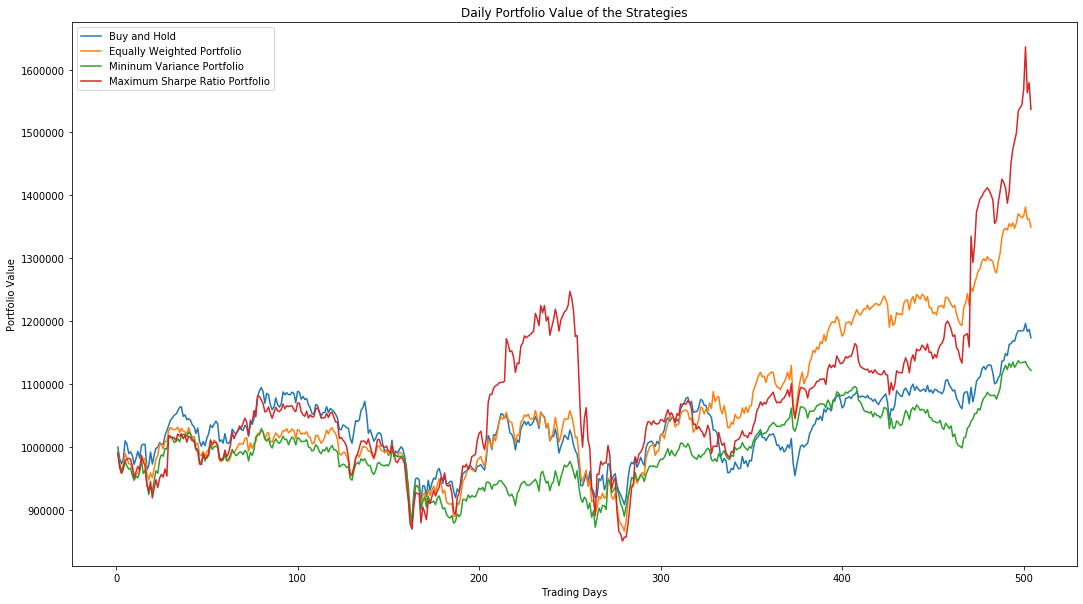

In [79]:
# Plot results
###################### Insert your code here ############################
#This chart illustrates the daily value of the portfolio for each strategy.

trading_days = list(range(1,N_days+1))
plt.figure(figsize=(18,10))
for i in range(N_strat):
  plt.plot(trading_days ,portf_value[i],label=strategy_names[i])
plt.legend()
plt.title('Daily Portfolio Value of the Strategies')
plt.ylabel('Portfolio Value')
plt.xlabel('Trading Days')
plt.show()

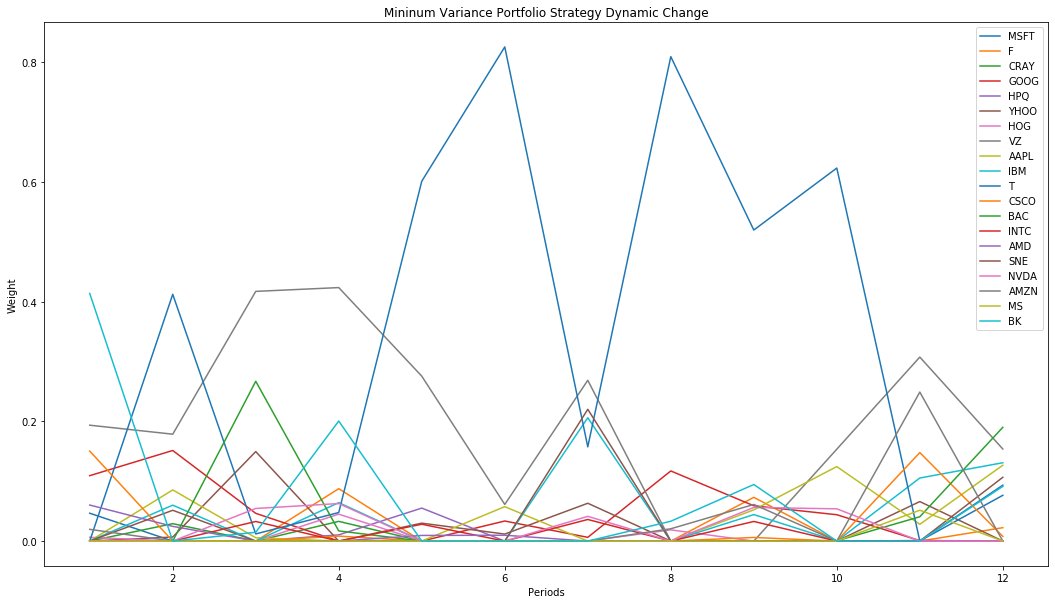

In [80]:
#This chart illustrates the dynamic changes of weights of each assets for strategy 3.
periods = list(range(1,N_periods+1))
stock_name = list(df.columns)[1:]
weight_stra3 = [weight_list_all[i][2] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
  plt.plot(periods, [weight_stra3[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Mininum Variance Portfolio Strategy Dynamic Change')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

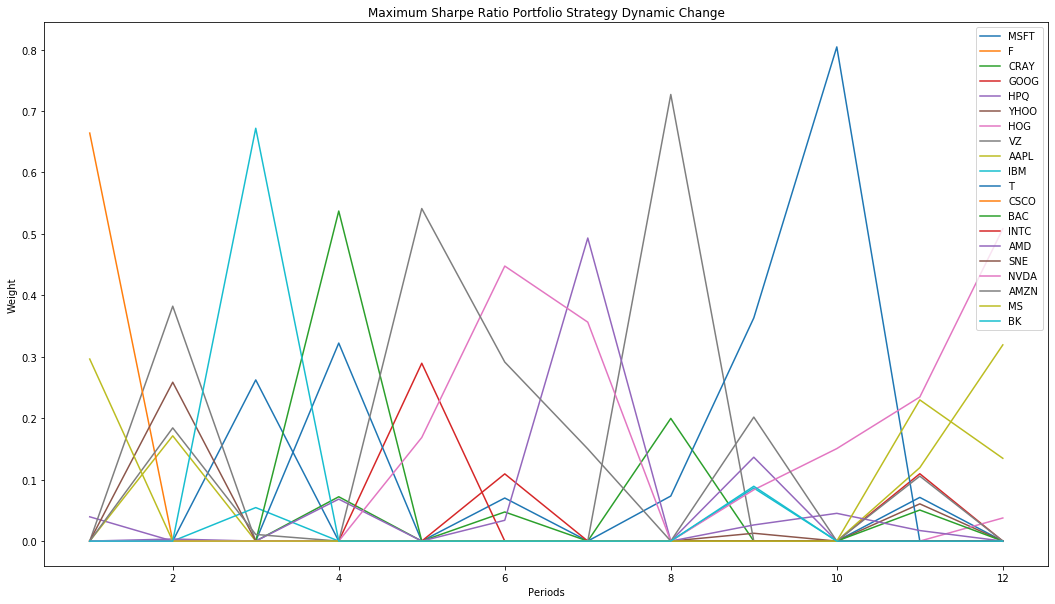

In [81]:
#This chart illustrates the dynamic changes of weights of each assets for strategy 4.
weight_stra4 = [weight_list_all[i][3] for i in range(0,12)]
plt.figure(figsize=(18,10))
for i in range(N): #N=20
  plt.plot(periods, [weight_stra4[k][i] for k in range(0,12)], label=stock_name[i])
plt.legend()
plt.title('Maximum Sharpe Ratio Portfolio Strategy Dynamic Change')
plt.ylabel('Weight')
plt.xlabel('Periods')
plt.show()

In [82]:
##Buy and Hold Equally Weighted (BHEW)
##The following code is the test for variation of my strategies.
##We first test the Buy and Hold Equally Weighted. We use the equally weighted strategy in the first period then hold it until the end.

x_BHEW = np.zeros((N_periods),  dtype=np.ndarray)
cash_BHEW = np.zeros((N_periods),  dtype=np.ndarray)
portf_value_BHEW = [0]*1
for period in range(1, N_periods+1):
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)
   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   cur_prices = data_prices[day_ind_start,:]
   if period == 1:
       curr_positions = init_positions
       curr_cash = 0
       portf_value_BHEW = np.zeros((N_days, 1))  #N_days = 504
       x_BHEW[period-1], cash_BHEW[period-1] = fh_array[1](curr_positions, curr_cash, mu, Q, cur_prices)
       if cash_BHEW[period-1] < 0:
         portfolio_price_rebalanced = np.dot(x_BHEW[period-1], cur_prices) + cash_BHEW[period-1]
         portfolio_price_initial = np.dot(curr_positions, cur_prices) + curr_cash
         weight = x_BHEW[period-1] * cur_prices / portfolio_price_rebalanced
         x_delta_accurate = cash_BHEW[period-1] * weight / cur_prices
         x_delta = np.floor(x_delta_accurate)
         x_adjusted = x_BHEW[period-1] + x_delta
         transaction_fee = np.dot(np.absolute(x_adjusted - curr_positions), cur_prices)*0.005
         cash_BHEW[period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices)
         x_BHEW[period-1] = x_adjusted
   else:
       curr_positions = x_BHEW[period-2]
       curr_cash = cash_BHEW[period-2]
       x_BHEW[period-1], cash_BHEW[period-1] = fh_array[0](curr_positions, curr_cash, mu, Q, cur_prices)
   p_values_BHEW = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x_BHEW[period-1]) + cash_BHEW[period-1]
   portf_value_BHEW[day_ind_start:day_ind_end+1] = np.reshape(p_values_BHEW, (p_values_BHEW.size,1))      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

In [83]:
##Maximum Sharpe Ratio with Half Transactions (MSRHT)
##We then test another variation of strategies. We use the Maximum Sharpe Ratio Strategy but only trade 6 times instead of 12 times within 2 years.

x_MSRHT = np.zeros((N_periods),  dtype=np.ndarray)
cash_MSRHT = np.zeros((N_periods),  dtype=np.ndarray)
portf_value_MSRHT = [0]*1
for period in range(1, N_periods+1): 
   if dates_array[0, 0] == 15:
       cur_year  = 15 + math.floor(period/7)
   else:
       cur_year  = 2015 + math.floor(period/7)
   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   cur_prices = data_prices[day_ind_start,:]
   if period == 1:
       curr_positions = init_positions
       curr_cash = 0
       portf_value_MSRHT = np.zeros((N_days, 1)) #N_days = 504
       x_MSRHT[period-1], cash_MSRHT[period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
   elif period in (2, 4, 6, 8, 10, 12):
       curr_positions = x_MSRHT[period-2]
       curr_cash = cash_MSRHT[period-2]
       x_MSRHT[period-1], cash_MSRHT[period-1] = curr_positions, curr_cash
   else:
       curr_positions = x_MSRHT[period-2]
       curr_cash = cash_MSRHT[period-2]
       x_MSRHT[period-1], cash_MSRHT[period-1] = fh_array[3](curr_positions, curr_cash, mu, Q, cur_prices)
   if cash_MSRHT[period-1] < 0:
         portfolio_price_rebalanced = np.dot(x_MSRHT[period-1], cur_prices) + cash_MSRHT[period-1]
         portfolio_price_initial = np.dot(curr_positions, cur_prices) + curr_cash
         weight = x_MSRHT[period-1] * cur_prices / portfolio_price_rebalanced
         x_delta_accurate = cash_MSRHT[period-1] * weight / cur_prices
         x_delta = np.floor(x_delta_accurate)
         x_adjusted = x_MSRHT[period-1] + x_delta
         transaction_fee = np.dot(np.absolute(x_adjusted - curr_positions), cur_prices)*0.005
         cash_MSRHT[period-1] = portfolio_price_initial - transaction_fee - np.dot(x_adjusted, cur_prices)
         x_MSRHT[period-1] = x_adjusted

   p_values_MSRHT = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x_MSRHT[period-1]) + cash_MSRHT[period-1]
   portf_value_MSRHT[day_ind_start:day_ind_end+1] = np.reshape(p_values_MSRHT, (p_values_MSRHT.size,1))      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)

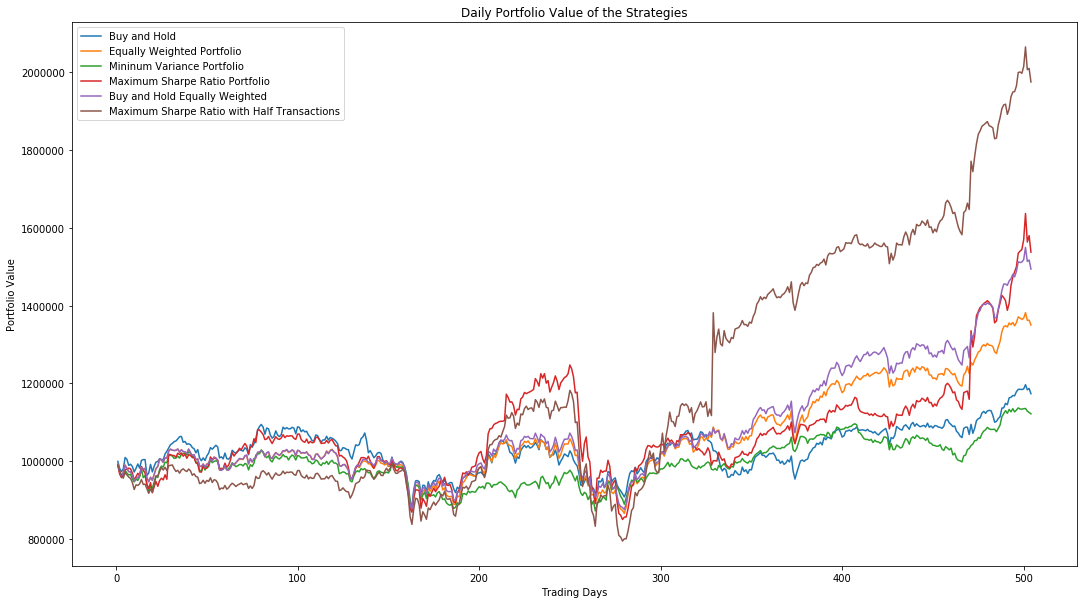

In [84]:
# Plot results
###################### Insert your code here ############################
##The following plot compares the performance for the 4 original strategies and the 2 improvement variations of our strategies.
##We can see that the Maximum Sharpe Ratio with Half Transactions performs best, which has a final portfolio value of about $1.9 million.

strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
trading_days = list(range(1,N_days+1))
plt.figure(figsize=(18,10))
for i in range(N_strat):
  plt.plot(trading_days ,portf_value[i],label=strategy_names[i])
plt.plot(trading_days,portf_value_BHEW,label='Buy and Hold Equally Weighted')
plt.plot(trading_days,portf_value_MSRHT,label='Maximum Sharpe Ratio with Half Transactions')
plt.legend()
plt.title('Daily Portfolio Value of the Strategies')
plt.ylabel('Portfolio Value')
plt.xlabel('Trading Days')
plt.show()